# Classificació d'instruments

En aquest treball ens bassarem en la base de dades accessible a https://www.upf.edu/web/mtg/irmas, que consta d'àudios de 2 segons de durada en format wav (format de compressió d'àudios sense pèrdua) on aparèixen múltiples instruments musicals, etiquetats pels instruments que aparèixen en els àudios. L'objectiu del treball serà trobar un model capaç de classificar els àudios segons els instruments que hi aparèixen.


## Preparació Model simple

Els àudios es transformaran en espectrogramas que contindran la informació de les diferents freqüències que aparèixen en aquests en cada instant de temps. A partir d'aquest espectrograma s'identificarà els instruments dels àudios, tractant els àudios com a imatges i utilitzant tècniques de visió per computador.

Per exemple, a continuació es mostra l'espectrograma obtigut per al primer àudio de la base de dades.

Text(0, 0.5, 'Freqüència')

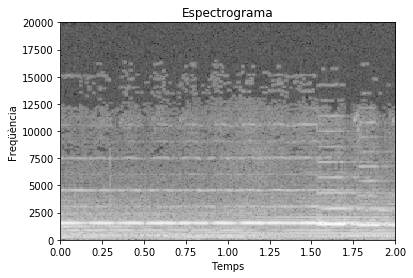

In [2]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import glob
import shutil
import os
import cv2

samplingFrequency, signalData = wavfile.read('Training/[cel][cla]0001__1.wav')
signalData1 = signalData[:, 0]
plt.title('Espectrograma')    
Pxx, freqs, bins, im = plt.specgram(signalData1,Fs=samplingFrequency,NFFT=512, cmap="gray")
plt.xlim(left=0,right=2)
plt.ylim(bottom=0,top=20000)
plt.xlabel("Temps")
plt.ylabel("Freqüència")

Tot i que s'ha de tenir en compte que les imatges que s'utilitzarán en l'entrenament i la classificació del model s'hauran de guardar sense la informació dels eixos. A més a més, com es tracta d'àudios estereo, es generaran dos imatges per cada àudio, una per cada canal. És a dir, per cada mostra de la base de dades, s'utilitzaran dues imatges i una llista d'instruments musicals.

Per exemple, el següent codi obté els dos espectrogrames corresponents al mateix àudio que s'ha tractat abans.

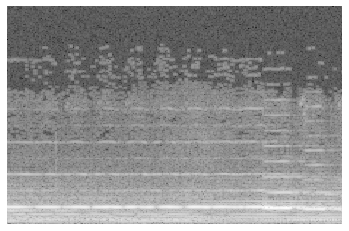

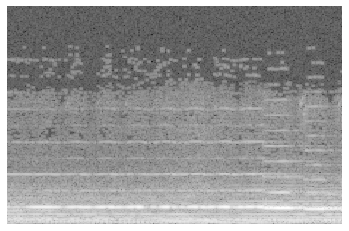

In [3]:
samplingFrequency, signalData = wavfile.read('Training/[cel][cla]0001__1.wav')

signalData1 = signalData[:, 0]
Pxx, freqs, bins, im = plt.specgram(signalData1,Fs=samplingFrequency,NFFT=512, cmap="gray")
plt.xlim(left=0,right=2)
plt.ylim(bottom=0,top=20000)
plt.axis('off')
plt.show()

signalData2 = signalData[:, 1]
Pxx, freqs, bins, im = plt.specgram(signalData2,Fs=samplingFrequency,NFFT=512, cmap="gray")
plt.xlim(left=0,right=2)
plt.ylim(bottom=0,top=20000)
plt.axis('off')
plt.show()

Les següents funcions permeten guardar els dos espectrogrames per a l'àudio en el path indicat, i en la  carpeta de destinació desitjada.

In [4]:
def insert_substring(string1, string2):

  beginning_substring = string1[:-4]
  ending_substring = string1[-4:]

  inserted_string = beginning_substring + string2 + '.png'
  return inserted_string

def audio2spect(audio, nom):
  fig = plt.figure()
  Pxx, freqs, bins, im = plt.specgram(audio,Fs=samplingFrequency,NFFT=512, cmap="gray")
  plt.xlim(left=0,right=2)
  plt.ylim(bottom=0,top=20000)
  plt.axis('off')
  plt.savefig(nom, bbox_inches='tight', dpi=300, frameon='false')
  plt.close(fig)

def processAudio(path, nom):
  samplingFrequency, signalData = wavfile.read(path)

  signalData1 = signalData[:, 0]
  audio2spect(signalData1, insert_substring(nom, '_1'))

  signalData2 = signalData[:, 1]
  audio2spect(signalData2, insert_substring(nom, '_2'))


El següent codi utilitza aquestes funcions per a guardar els espectrogrames corresponents als audios del conjunt de train (ja especificat per la base de dades) a la carpeta "Train_images", i els espectrogrames corresponents als audios del conjunt de test a la carpeta "Test_images".

In [ ]:
for wavf in glob.iglob(os.path.join('Training', "*.wav")):
  try:
    dst = wavf[8:]
    dst = 'Train_images/' + dst
    
    processAudio(wavf, dst)
  except Exception as e:
    print(wavf)
    print(e)

for wavf in glob.iglob(os.path.join('Test', "*.wav")):
  try:
    dst = wavf[5:]
    dst = 'Test_images/' + dst
    
    processAudio(wavf, dst)
  except Exception as e:
    print(wavf)
    print(e)

C:\Users\Biel\anaconda\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  from ipykernel import kernelapp as app


En el conjunt de training, les etiquetes dels instruments estan contingudes en el mateix nom del fitxer. Les següents funcions permeten obtenir, a partir del nom d'un fitxer, un array de booleans indicant amb quins instruments ha estat etiquetat.

In [5]:
labels = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']

def is_label_train(label, name):
    return '[' + label + ']' in name

def get_labels_train(name):
    c = [is_label_train(labels[i], name) for i in range(len(labels))]
    return np.array(c)

A partir d'aquestes funcions, es prepara un array d'imatges (l'input) i un altre de labels (l'expected output) del conjunt d'entrenament, que s'utilitzaran per a entrenar el model.

In [6]:
train_size = 1000
files = []
for wavf in glob.iglob(os.path.join('Train_images', "*_1.png")):
    files.append(wavf)
files = files[:train_size]

im = cv2.imread(files[0])
im = cv2.resize(im, (256,256))
#im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
shape_array = (train_size,) + im.shape#[:3]

label_train = np.zeros((train_size,11))
images_train = np.zeros(shape_array)

for i in range(len(files)):
    file = files[i]
    im = cv2.imread(file)
    im = cv2.resize(im, (256,256))
    im = im / 255.0
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    images_train[i,:,:,:] = im
    label_train[i, :] = get_labels_train(file)

En el cas del conjunt de test, la base de dades etiquetava els audios de forma diferent, a partir de txts inclosos en aquesta. Les següents funcions permeten extreure les etiquetes d'un audio del conjunt de test a partir del nom del fitxer.

In [ ]:
def is_label_test(label, name):
    with open(name) as f:
        return label in f.read()

def get_labels_test(name):
    name = name[14:]
    name = name[:-6]
    name = 'Test/' + name + '.txt'
    
    c = [is_label_test(labels[i], name) for i in range(len(labels))]
    return np.array(c)

get_labels_test(files[2])

Per tant, ara sí, es prepara també el conjunt de test.

In [ ]:
test_size = 200
files = []
for wavf in glob.iglob(os.path.join('Test_images', "*_1.png")):
    files.append(wavf)
files = files[:test_size]

im = cv2.imread(files[0])
print(im)
im = cv2.resize(im, (256,256))
#im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
shape_array = (test_size,) + im.shape#[:3]

label_test = np.zeros((test_size,11))
images_test = np.zeros(shape_array)

for i in range(len(files)):
    try:
        file = files[i]
        im = cv2.imread(file)
        im = cv2.resize(im, (256,256))
        im = im / 255.0
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        images_test[i,:,:, :] = im
        label_test[i, :] = get_labels_test(file)
    except Exception as e:
        print(e)
        print(files[i])

## Training del model simple
Primer, particionem les dades d'entrenament en un conjunt de d'entrenament i un de validació

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images_train, label_train, test_size=0.2, random_state=44)

Declarem un primer model que parteix de la xarxa pre-entrenada VGG16.

In [ ]:
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input, Dropout, MaxPooling2D

inputs = Input(images_train.shape[1:])

# Crida al model BGG16 
vgg16 = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=images_train.shape[1:],
    classifier_activation="sigmoid",
)

# No és necessari entrenar-lo, ja estava pre-entrenat
vgg16.trainable = False

# S'afegeixen capes extra per a la classificació.
X = vgg16(inputs)
X = Flatten()(X)
X = Dense(400, activation='relu')(X)
X = Dense(400, activation='relu')(X)
X = Dropout(0.5)(X)
outputs = Dense(11, activation='softmax')(X)

cnn_model = keras.Model(inputs, outputs)

Model propi que no parteix de cap preentrenat.

In [ ]:
input_shape=images_train.shape[1:]
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='sigmoid'))

In [ ]:
from keras.optimizers import SGD

model.compile(
    optimizer=SGD(learning_rate=0.1, momentum=0.01),
    loss="binary_crossentropy",
    #loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    )

In [ ]:
model.fit(dataset_train, 
              validation_data=dataset_val, 
              epochs=20,
             )

## Preparació Model elaborat

En aquesta secció es prepararà el model elaborat explicat a l'informe.

In [2]:
import IPython.display as ipd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
import tensorflow as tf
from PIL import Image
import png

D'entrada processem els gràfics a partir de l'àudio fent les mitjanes en l'eix horitzontal, per al model combinat.

In [ ]:
files = []
for wavf in glob.iglob(os.path.join('Training', "*wav")):
    files.append(wavf)
#files[:300]

im = cv2.imread(files[0])
im = cv2.resize(im, (256,256))
#im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
shape_array = (train_size,) + im.shape#[:3]

label_train = np.zeros((train_size,11))
images_train = np.zeros(shape_array)
 

for i in range(len(files)):
    file = files[i]
    im = cv2.imread(file)
    im = cv2.resize(im, (256,256))
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    images_train[i,:,:,:] = im
    label_train[i, :] = get_labels_train(file)
    
    
mfc=[]
chra=[]
me=[]
ton=[]
lab=[]

for i in range(len(files)):
    print(i)
    f_name=files[i]
    X, s_rate = librosa.load(f_name, res_type='kaiser_fast')
    mf = np.mean(librosa.feature.mfcc(y=X, sr=s_rate).T,axis=0)
    mfc.append(mf)
    l=get_labels_train(f_name)
    lab.append(l)
    try:
        t =    np.mean(librosa.feature.tonnetz(
                       y=librosa.effects.harmonic(X),
                       sr=s_rate).T,axis=0)
        ton.append(t)
    except:
        print(f_name)  
    m = np.mean(librosa.feature.melspectrogram(X, sr=s_rate).T,axis=0)
    me.append(m)
    s = np.abs(librosa.stft(X))
    c = np.mean(librosa.feature.chroma_stft(S=s, sr=s_rate).T,axis=0)
    chra.append(c)

Es guarden els resultats.

In [ ]:
mfcc = pd.DataFrame(mfc)
mfcc.to_csv('train/mfc.csv', index=False)
chrr = pd.DataFrame(chra)
chrr.to_csv('train/chr.csv', index=False)
mee = pd.DataFrame(me)
mee.to_csv('train/me.csv', index=False)
tonn = pd.DataFrame(ton)
tonn.to_csv('train/ton.csv', index=False)
la = pd.DataFrame(lab)
la.to_csv('train/labels.csv', index=False)

Es farà el mateix però sense computar les mitjanes

In [109]:
files = []
for wavf in glob.iglob(os.path.join('Training', "*wav")):
    files.append(wavf)
#files[:300]

im = cv2.imread(files[0])
im = cv2.resize(im, (256,256))
#im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
shape_array = (train_size,) + im.shape#[:3]

label_train = np.zeros((train_size,11))
images_train = np.zeros(shape_array)


for i in range(len(files)):
    file = files[i]
    im = cv2.imread(file)
    im = cv2.resize(im, (256,256))
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    images_train[i,:,:,:] = im
    label_train[i, :] = get_labels_train(file)
    
    
mfc=[]
chra=[]
me=[]
ton=[]
lab=[]

for i in range(len(files)):
    print(i)
    f_name=files[i]
    X, s_rate = librosa.load(f_name, res_type='kaiser_fast')
    mf = librosa.feature.mfcc(y=X, sr=s_rate).T
    mfc.append(mf)
    l=get_labels_train(f_name)
    lab.append(l)
    try:
        t =    librosa.feature.tonnetz(
                       y=librosa.effects.harmonic(X),
                       sr=s_rate).T
        ton.append(t)
    except:
        print(f_name)  
    m = librosa.feature.melspectrogram(X, sr=s_rate).T
    me.append(m)
    s = np.abs(librosa.stft(X))
    c = librosa.feature.chroma_stft(S=s, sr=s_rate).T
    chra.append(c)

In [140]:
#6705, 130, 20
mfc2 = np.array(mfc).reshape(6705,mfc[0].shape[0]*mfc[0].shape[1])
chra2 = np.array(chra).reshape(6705,chra[0].shape[0]*chra[0].shape[1])
me2 = np.array(me).reshape(6705,me[0].shape[0]*me[0].shape[1])
ton2 = np.array(ton).reshape(6705,ton[0].shape[0]*ton[0].shape[1])

In [ ]:
mfcc = pd.DataFrame(mfc2)
mfcc.to_csv('train/mfc.csv', index=False)
chrr = pd.DataFrame(chra2)
chrr.to_csv('train/chr.csv', index=False)
mee = pd.DataFrame(me2)
mee.to_csv('train/me.csv', index=False)
tonn = pd.DataFrame(ton2)
tonn.to_csv('train/ton.csv', index=False)
'''la = pd.DataFrame(lab)
la.to_csv('Biel_test/labels.csv', index=False)'''

En cas que volguem carregar-les, executem directament aquesta casella. Deixem la cel·la llesta per més endavant.

In [ ]:
# Variebles de train
mfc = pd.read_csv('train/mfc.csv', header=0, delimiter=',').to_numpy()
chra = pd.read_csv('train/chr.csv', header=0, delimiter=',').to_numpy()
me = pd.read_csv('train/me.csv', header=0, delimiter=',').to_numpy()
ton = pd.read_csv('train/ton.csv', header=0, delimiter=',').to_numpy()
lab = pd.read_csv('train/labels.csv', header=0, delimiter=',').to_numpy()
# Variebles de test
mfct = pd.read_csv('test/mfc.csv', header=0, delimiter=',').to_numpy()
chra = pd.read_csv('test/chr.csv', header=0, delimiter=',').to_numpy()
met = pd.read_csv('test/me.csv', header=0, delimiter=',').to_numpy()
tont = pd.read_csv('test/ton.csv', header=0, delimiter=',').to_numpy()
labt = pd.read_csv('test/labels.csv', header=0, delimiter=',').to_numpy()

In [85]:
features = []
for i in range(len(ton)):
    features.append(np.concatenate((me[i], mfc[i], 
                ton[i], chra[i]), axis=0))

features_test = []
for i in range(len(tont)):
    features_test.append(np.concatenate((met[i], mfct[i], 
                tont[i], chrat[i]), axis=0))

lab2 = lab
lab = []
for i in range(len(lab2)):
    labs = lab2[i]
    string = []
    for j in labs:
        if j:
            string.append(1)
        else:
            string.append(0)
    lab.append(string)

lab2 = labt
labt = []
for i in range(len(lab2)):
    labs = lab2[i]
    string = []
    for j in labs:
        if j:
            string.append(1)
        else:
            string.append(0)
    labt.append(string)

In [86]:
target = np.array(lab)
target_test = np.array(labt)

Estandarditzem les dades.

In [ ]:
tran = StandardScaler()
features_train = tran.fit_transform(features)
features_train = np.expand_dims(features_train, 2)
x_train, x_val, y_train, y_val = train_test_split(features_train, target, test_size=0.2, random_state=44)
features_test = tran.transform(features_test)

Primer, però, entrenarem els models individuals.

In [ ]:
mfc = pd.read_csv('train_images/mfc.csv', header=0, delimiter=',').to_numpy()
chra = pd.read_csv('train_images/chr.csv', header=0, delimiter=',').to_numpy()
me = pd.read_csv('train_images/me.csv', header=0, delimiter=',').to_numpy()
ton = pd.read_csv('train_images/ton.csv', header=0, delimiter=',').to_numpy()
lab = pd.read_csv('train_images/labels.csv', header=0, delimiter=',').to_numpy()

In [ ]:
features = mfc # Ho canviarem per cada característica.
tran = StandardScaler()
features_train = tran.fit_transform(features)

In [ ]:
# mfc
features_train = np.reshape(features_train, (6705, 130, 20, 1))
# chra
#features_train = np.reshape(features_train, (6705, 130, 12, 1))
# me
#features_train = np.reshape(features_train, (6705, 130, 128, 1))
# ton
# features_train = np.reshape(features_train, (6705, 130, 6, 1))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(features_train, target, test_size=0.2, random_state=44)

In [ ]:
input_shape = features_train.shape[1:]

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              metrics=['accuracy',tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR'), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()], 
              optimizer=SGD(learning_rate=0.1, momentum=0.01),
             )

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=20, 
                    validation_data=(x_val, y_val))

Ara preparem el model combinat per a la Grid Search.

In [ ]:
def create_model(learning_rate=0.1, momentum=0.01, init_mode='normal'):
    print(learning_rate, momentum, init_mode)
    model = Sequential()
    model.add(Dense(128, activation = 'tanh', kernel_initializer=init_mode, input_shape=(features_train.shape[1], 1)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(target.shape[1], activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  metrics=['accuracy'], 
                  optimizer=SGD(learning_rate=learning_rate, momentum=momentum),
                 )
    return model

I l'executem.

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# fix random seed for reproducibility
seed = 44
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=16, verbose=0)

# define the grid search parameters
learn_rate = [0.01, 0.1]
momentum = [0.1, 0.01]
init_mode = ['normal', 'he_uniform']
param_grid = dict(learning_rate=learn_rate, momentum=momentum, init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=ShuffleSplit(test_size=0.20, n_splits=1, random_state=42))
grid_result = grid.fit(features_train, target)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Un cop coneixem els millors hiperparàmetres, entrenem el model amb les dades de training i calculem les mètriques finals.

In [96]:
model = Sequential()
model.add(Dense(128, activation = 'tanh', kernel_initializer='he_uniform', input_shape=(features_train.shape[1], 1)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(target.shape[1], activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR'), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()], 
              optimizer=SGD(learning_rate=0.1, momentum=0.1),
             )
history = model.fit(x_train, y_train, batch_size=16, epochs=20, 
                    validation_data=(x_val, y_val))

In [ ]:
history = model.fit(feat_train, target_train, batch_size=16, epochs=30, 
                    validation_data=(y_train, y_val))

In [ ]:
import sklearn.metrics as skm

y_pred = model.predict(features_test, batch_size=64, verbose=1)

cm = skm.multilabel_confusion_matrix(target_test, y_pred > 0.5)

print(cm)
print( skm.classification_report(target_test, y_pred > 0.5))